# How to Build a RAG-Powered Chatbot with Chat, Embed, and Rerank

*Read the accompanying [blog post here](#https://txt.cohere.com/rag-chatbot).*

In this notebook, you’ll learn how to build a chatbot that has RAG capabilities, enabling it to connect to external documents, ground its responses on these documents, and produce document citations in its responses.

Below is a diagram that provides an overview of what we’ll build, followed by a list of the key steps involved.

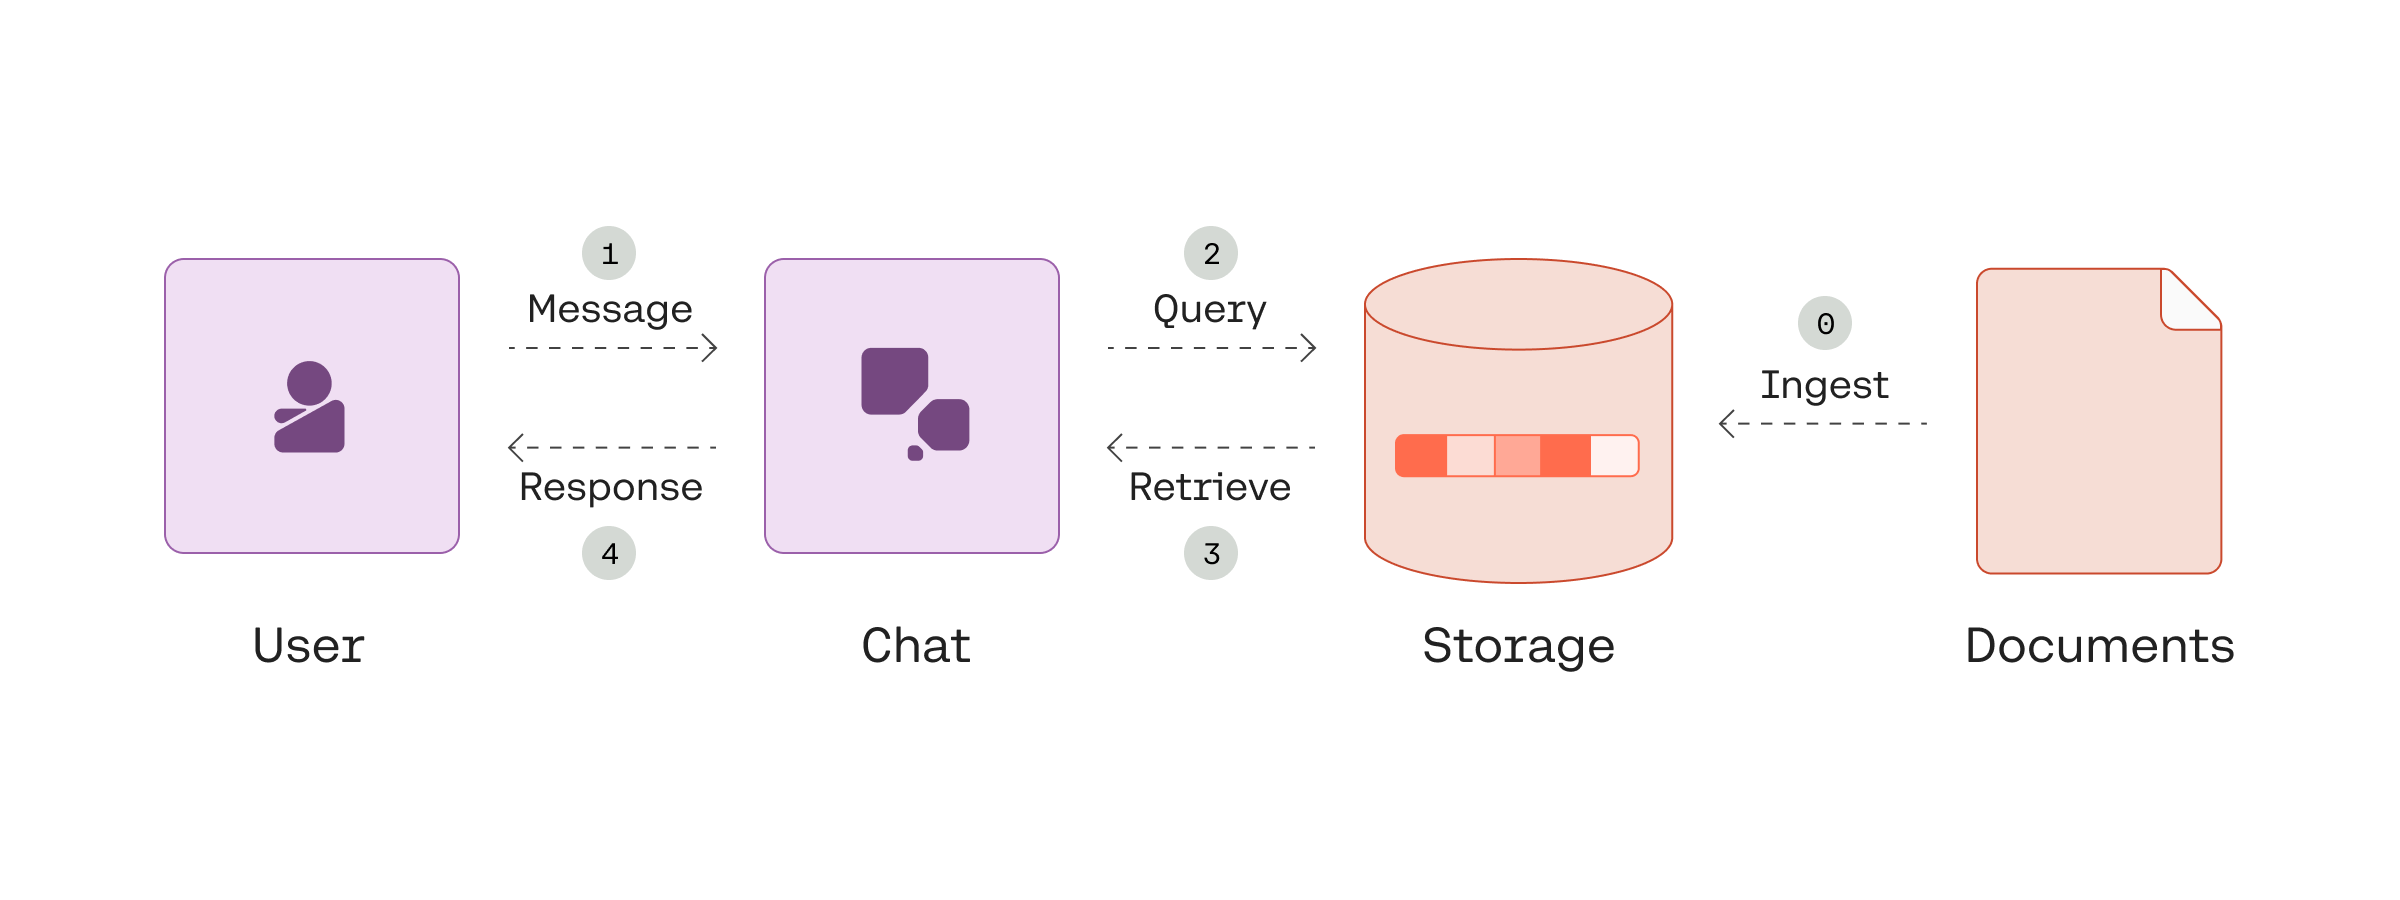

Setup phase:
- Step 0: Ingest the documents – get documents, chunk, embed, and index.

For each user-chatbot interaction:
- Step 1: Get the user message
- Step 2: Call the Chat endpoint in query-generation mode
- If at least one query is generated
    - Step 3: Retrieve and rerank relevant documents
    - Step 4: Call the Chat endpoint in document mode to generate a grounded response with citations
- If no query is generated
    - Step 4: Call the Chat endpoint in normal mode to generate a response

Throughout the conversation:
- Append the user-chatbot interaction to the conversation thread
- Repeat with every interaction

In [ ]:
! pip install cohere hnswlib unstructured -q

In [1]:
import cohere
import os
import hnswlib
import json
import uuid
from typing import List, Dict
from unstructured.partition.html import partition_html
from unstructured.chunking.title import chunk_by_title

co = cohere.Client(os.environ["COHERE_API_KEY"])

In [2]:
#@title Enable text wrapping in Google colab

from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

### Documents component

In [3]:
class Documents:
    """
    A class representing a collection of documents.

    Parameters:
    sources (list): A list of dictionaries representing the sources of the documents. Each dictionary should have 'title' and 'url' keys.

    Attributes:
    sources (list): A list of dictionaries representing the sources of the documents.
    docs (list): A list of dictionaries representing the documents, with 'title', 'content', and 'url' keys.
    docs_embs (list): A list of the associated embeddings for the documents.
    retrieve_top_k (int): The number of documents to retrieve during search.
    rerank_top_k (int): The number of documents to rerank after retrieval.
    docs_len (int): The number of documents in the collection.
    index (hnswlib.Index): The index used for document retrieval.

    Methods:
    load(): Loads the data from the sources and partitions the HTML content into chunks.
    embed(): Embeds the documents using the Cohere API.
    index(): Indexes the documents for efficient retrieval.
    retrieve(query): Retrieves documents based on the given query.

    """

    def __init__(self, sources: List[Dict[str, str]]):
        self.sources = sources
        self.docs = []
        self.docs_embs = []
        self.retrieve_top_k = 10
        self.rerank_top_k = 3
        self.load()
        self.embed()
        self.index()

    def load(self) -> None:
        """
        Loads the documents from the sources and chunks the HTML content.
        """
        print("Loading documents...")

        for source in self.sources:
            elements = partition_html(url=source["url"])
            chunks = chunk_by_title(elements)
            for chunk in chunks:
                self.docs.append(
                    {
                        "title": source["title"],
                        "text": str(chunk),
                        "url": source["url"],
                    }
                )

    def embed(self) -> None:
        """
        Embeds the documents using the Cohere API.
        """
        print("Embedding documents...")

        batch_size = 90
        self.docs_len = len(self.docs)

        for i in range(0, self.docs_len, batch_size):
            batch = self.docs[i : min(i + batch_size, self.docs_len)]
            texts = [item["text"] for item in batch]
            docs_embs_batch = co.embed(
                texts=texts, model="embed-english-v3.0", input_type="search_document"
            ).embeddings
            self.docs_embs.extend(docs_embs_batch)

    def index(self) -> None:
        """
        Indexes the documents for efficient retrieval.
        """
        print("Indexing documents...")

        self.idx = hnswlib.Index(space="ip", dim=1024)
        self.idx.init_index(max_elements=self.docs_len, ef_construction=512, M=64)
        self.idx.add_items(self.docs_embs, list(range(len(self.docs_embs))))

        print(f"Indexing complete with {self.idx.get_current_count()} documents.")

    def retrieve(self, query: str) -> List[Dict[str, str]]:
        """
        Retrieves documents based on the given query.

        Parameters:
        query (str): The query to retrieve documents for.

        Returns:
        List[Dict[str, str]]: A list of dictionaries representing the retrieved documents, with 'title', 'text', and 'url' keys.
        """
        docs_retrieved = []
        query_emb = co.embed(
            texts=[query], model="embed-english-v3.0", input_type="search_query"
        ).embeddings

        doc_ids = self.idx.knn_query(query_emb, k=self.retrieve_top_k)[0][0]

        docs_to_rerank = []
        for doc_id in doc_ids:
            docs_to_rerank.append(self.docs[doc_id]["text"])

        rerank_results = co.rerank(
            query=query,
            documents=docs_to_rerank,
            top_n=self.rerank_top_k,
            model="rerank-english-v2.0",
        )

        doc_ids_reranked = []
        for result in rerank_results:
            doc_ids_reranked.append(doc_ids[result.index])

        for doc_id in doc_ids_reranked:
            docs_retrieved.append(
                {
                    "title": self.docs[doc_id]["title"],
                    "text": self.docs[doc_id]["text"],
                    "url": self.docs[doc_id]["url"],
                }
            )

        return docs_retrieved

### Chatbot component

In [4]:
class Chatbot:
    """
    A class representing a chatbot.

    Parameters:
    docs (Documents): An instance of the Documents class representing the collection of documents.

    Attributes:
    conversation_id (str): The unique ID for the conversation.
    docs (Documents): An instance of the Documents class representing the collection of documents.

    Methods:
    generate_response(message): Generates a response to the user's message.
    retrieve_docs(response): Retrieves documents based on the search queries in the response.

    """

    def __init__(self, docs: Documents):
        self.docs = docs
        self.conversation_id = str(uuid.uuid4())

    def generate_response(self, message: str):
        """
        Generates a response to the user's message.

        Parameters:
        message (str): The user's message.

        Yields:
        Event: A response event generated by the chatbot.

        Returns:
        List[Dict[str, str]]: A list of dictionaries representing the retrieved documents.

        """
        # Generate search queries (if any)
        response = co.chat(message=message, search_queries_only=True)

        # If there are search queries, retrieve documents and respond
        if response.search_queries:
            print("Retrieving information...")

            documents = self.retrieve_docs(response)

            response = co.chat(
                message=message,
                documents=documents,
                conversation_id=self.conversation_id,
                stream=True,
            )
            for event in response:
                yield event

        # If there is no search query, directly respond
        else:
            response = co.chat(
                message=message, 
                conversation_id=self.conversation_id, 
                stream=True
            )
            for event in response:
                yield event

    def retrieve_docs(self, response) -> List[Dict[str, str]]:
        """
        Retrieves documents based on the search queries in the response.

        Parameters:
        response: The response object containing search queries.

        Returns:
        List[Dict[str, str]]: A list of dictionaries representing the retrieved documents.

        """
        # Get the query(s)
        queries = []
        for search_query in response.search_queries:
            queries.append(search_query["text"])

        # Retrieve documents for each query
        retrieved_docs = []
        for query in queries:
            retrieved_docs.extend(self.docs.retrieve(query))

        # # Uncomment this code block to display the chatbot's retrieved documents
        # print("DOCUMENTS RETRIEVED:")
        # for idx, doc in enumerate(retrieved_docs):
        #     print(f"doc_{idx}: {doc}")
        # print("\n")

        return retrieved_docs

### App component

In [5]:
class App:
    def __init__(self, chatbot: Chatbot):
        """
        Initializes an instance of the App class.

        Parameters:
        chatbot (Chatbot): An instance of the Chatbot class.

        """
        self.chatbot = chatbot
    
    def run(self):
        """
        Runs the chatbot application.

        """
        while True:
            # Get the user message
            message = input("User: ")

            # Typing "quit" ends the conversation
            if message.lower() == "quit":
                print("Ending chat.")
                break
            else:
                print(f"User: {message}")

            # Get the chatbot response
            response = self.chatbot.generate_response(message)

            # Print the chatbot response
            print("Chatbot:")
            flag = False
            for event in response:
                # Text
                if event.event_type == "text-generation":
                    print(event.text, end="")

                # Citations
                if event.event_type == "citation-generation":
                    if not flag:
                        print("\n\nCITATIONS:")
                        flag = True
                    print(event.citations)

            print(f"\n{'-'*100}\n")

### Define the documents

In [6]:
# Define the sources for the documents
# As an example, we'll use LLM University's Module 1: What are Large Language Models?
# https://docs.cohere.com/docs/intro-large-language-models

sources = [
    {
        "title": "Text Embeddings", 
        "url": "https://docs.cohere.com/docs/text-embeddings"},
    {
        "title": "Similarity Between Words and Sentences", 
        "url": "https://docs.cohere.com/docs/similarity-between-words-and-sentences"},
    {
        "title": "The Attention Mechanism", 
        "url": "https://docs.cohere.com/docs/the-attention-mechanism"},
    {
        "title": "Transformer Models", 
        "url": "https://docs.cohere.com/docs/transformer-models"}   
]

### Process the documents

In [9]:
# Create an instance of the Documents class with the given sources
documents = Documents(sources)

Loading documents...
Embedding documents...
Indexing documents...
Indexing complete with 136 documents.


### Run the chatbot

In [15]:
# Create an instance of the Chatbot class with the Documents instance
chatbot = Chatbot(documents)

# Create an instance of the App class with the Chatbot instance
app = App(chatbot)

# Run the chatbot
app.run()

User: Hi there
Chatbot:
Hi there! I'm Coral, an AI-assistant chatbot trained to assist human users by providing thorough responses. Is there anything I can help you with today?
----------------------------------------------------------------------------------------------------

User: What are text embeddings
Chatbot:
Retrieving information...
Text embeddings are used to convert words into numbers, creating a vector of numerical data for every piece of text. If the vectors for two pieces of text are similar, this means that the corresponding pieces of text are similar too, and vice versa. Text embeddings are particularly useful for tasks like machine translation and searching for text in different languages. 

Would you like me to go into more detail about any of the information mentioned above?

CITATIONS:
[{'start': 28, 'end': 54, 'text': 'convert words into numbers', 'document_ids': ['doc_1']}]
[{'start': 67, 'end': 116, 'text': 'vector of numerical data for every piece of text.', 'd